In [6]:
import pandas as pd
import numpy as np

from pydumbo import merchant_signals as MerchantSignals
from kplib.dumbo import Dumbo, DataframeInput, FeatureOptions,EvaluationOptions, FileInput

from sklearn.metrics import euclidean_distances
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
import sklearn.preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.stats import ks_2samp

from pysnowflake.simple import Session
from pysnowflake.utils import retrieve_query
from pysnowflake.utils import write_df_to_snowflake

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

import json
#import RiskarbiterService
#from pyriskarbiter.services.riskarbiter import RiskarbiterService
#from tqdm import tqdm


import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

from sklearn.model_selection import train_test_split #
from sklearn.tree import DecisionTreeClassifier
pd.options.display.max_columns = 25
pd.options.display.max_rows = 25
pd.set_option('display.float_format', '{:.2f}'.format)

from sklearn import metrics
import blocks
from blocks.filesystem import GCSFileSystem

pd.options.display.max_rows = 4000

In [5]:
!pip install pydumbo

Looking in indexes: https://pypi.org/simple, https://nexus3.sqcorp.co/repository/pypi-all/simple
  Created wheel for pydumbo: filename=pydumbo-0.5.5-py3-none-any.whl size=13554 sha256=fb9be0de60a313cf82150093b92eaf4659ee5668e37353ebc6cda09622c35e27
  Stored in directory: /tmp/pip-ephem-wheel-cache-jw57s2sw/wheels/70/08/b6/13d3d4125caddb0d9442330fb65ffe5cb7758a92e70f339f78
Successfully built pydumbo


In [2]:
with Session(app_name="APP_RISK") as ss:
    
    df = ss.download(
        table = "APP_RISK.APP_RISK_TEST.fnb_api_payments",
        path="gs://ds-risk-prod-snowstage/nmavani/fnb_emailage/data_snowflake/",
    )

In [8]:
signallist = [
'miles_from_buyer_ip_to_card_issuing_country_by_id_from_payment',
'miles_from_buyer_ip_to_buyer_shipping_zip_by_id_from_payment',
'miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment',
'miles_from_merchant_city_to_buyer_shipping_zip_by_id_from_payment',
'miles_from_merchant_city_to_buyer_zip_by_id_from_payment',
'miles_from_merchant_city_to_buyer_ip_by_id_from_payment',
'miles_from_buyer_zip_to_buyer_shipping_zip_by_id_from_payment',
'is_shipping_zip_present_by_id_from_payment',
'tip_amount_by_id_from_payment',
'avg_amount_by_merchant_from_payment_merchant',
'total_success_count_by_buyer_ip_from_payment_buyer_ip',
'total_declined_count_by_buyer_ip_from_payment_buyer_ip',
'total_declined_count_by_browser_fingerprint_from_payment_browser_fingerprint',
#'total_declined_count_in_52w1d_by_merchant_and_card_from_payment_merchant_and_card',
'total_declined_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card',
'total_success_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card',
'success_rate_by_amount_v2_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card',
'total_chargeback_v3_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card',
'success_rate_by_amount_v2_by_card_from_payment_card',
'success_rate_by_count_v2_by_card_from_payment_card',
'is_card_carding_blacklisted_by_card_from_payment_card',
'cnp_decline_rate_by_amount_by_card_from_payment_card',
'total_fraud_chargeback_amount_by_card_from_payment_card',
#'rapidrisk_email_exists_yes_by_email_from_payment_buyer_email',
'total_avs_mismatch_count_by_buyer_ip_from_payment_buyer_ip',
'total_avs_mismatch_count_by_card_from_payment_card',
'is_avs_mismatch_by_id_from_payment',
'is_cvv_unchecked_by_id_from_payment',
'is_cvv_rejected_by_id_from_payment',
'total_cvv_rejected_count_by_card_from_payment_card'
]

In [7]:
Dumbo().get_features(
        entity="REGISTER_PAYMENT",
        input_query=FileInput("gs://ds-risk-prod-snowstage/nmavani/fnb_emailage/data_snowflake", token_col="PAYMENT_TOKEN"),
        #output_path="gs://ds-risk-prod-snowstage/nmavani/acuity_api_202103/data_dumbo",
        output_path="gs://ds-risk-prod-snowstage/nmavani/fnb_emailage/data_dumbo",
        feature_options=FeatureOptions(
            features=signallist, 
            include_deprecated=False
        ),
        evaluation_options=EvaluationOptions(
            acl_reasons=["risk"]),
    )

In [ ]:
df_features = blocks.assemble('gs://ds-risk-prod-snowstage/nmavani/fnb_emailage/data_dumbo/results')

In [24]:
df_features.head()

,UNIT_TOKEN,PAYMENT_TOKEN,PAYMENT_TRX_RECOGNIZED_AT,AUTH_INTENT_CREATED_AT,PAY_WITH_SQUARE_ENTRY_METHOD,AMOUNT_BASE_UNIT,CURRENCY_CODE,IS_CURRENTLY_DEACTIVATED,IS_CURRENTLY_FROZEN,IS_REFUNDED,IS_GPV,DECLINE_REASONS,...,success_rate_by_amount_v2_by_card_from_payment_card,success_rate_by_count_v2_by_card_from_payment_card,is_card_carding_blacklisted_by_card_from_payment_card,cnp_decline_rate_by_amount_by_card_from_payment_card,total_fraud_chargeback_amount_by_card_from_payment_card,total_avs_mismatch_count_by_buyer_ip_from_payment_buyer_ip,total_avs_mismatch_count_by_card_from_payment_card,is_avs_mismatch_by_id_from_payment,is_cvv_unchecked_by_id_from_payment,is_cvv_rejected_by_id_from_payment,total_cvv_rejected_count_by_card_from_payment_card,timestamp
0,THRP29T2FJV21,VEPzdOZGnmA8aCMRe58NOaEVny9YY,2021-01-20 22:22:26.682000+00:00,2021-01-20 22:22:21.312000+00:00,EXTERNAL_API,7475.00,USD,0,0,0,1,[],...,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1611181341312
1,5HN9ARJ3KB5TD,RmRj1G6d5QDGN3Mw1oISipSxIdeZY,2021-03-17 15:01:25.807000+00:00,2021-03-17 15:01:20.316000+00:00,EXTERNAL_API,17298.00,USD,0,0,0,1,[],...,1.00,1.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,1615993280316
2,RB4654EAJD79Z,NCiSY4OTVLOLsMV3aXItnKN3jGFZY,2021-02-13 16:07:51.556000+00:00,2021-02-13 16:07:48.273000+00:00,EXTERNAL_API,3780.00,USD,0,0,0,1,[],...,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1613232468273
3,LJAXCPGFM2XDC,BCfHmvJB5LD1dGch14OKPJIpYjHZY,2021-03-21 10:42:46.834000+00:00,2021-03-21 10:42:41.496000+00:00,EXTERNAL_API,1996.00,USD,0,0,0,1,[],...,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1616323361496
4,XZD0SZ8KN2CJN,7tUieWIp3WLW1g8gsQKhbHzulGcZY,2021-04-26 01:06:52.412000+00:00,2021-04-26 01:04:58.441000+00:00,EXTERNAL_API,7917.00,USD,0,0,0,1,[],...,0.90,0.88,0.00,0.10,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1619399098441


In [ ]:
df_features.shape

In [ ]:
print((df_features.isna().sum()*100/df_features['PAYMENT_TOKEN'].count()).sort_values())

In [ ]:
(df_features.describe()).T

In [ ]:
df_features['PAYMENT_TRX_RECOGNIZED_AT']= df_features['PAYMENT_TRX_RECOGNIZED_AT'].dt.strftime('%Y-%m-%d %H:%M:%S').fillna(pd.NaT)
df_features['AUTH_INTENT_CREATED_AT']=df_features['AUTH_INTENT_CREATED_AT'].dt.strftime('%Y-%m-%d %H:%M:%S').fillna(pd.NaT)

In [29]:
import pandas as pd
from pysnowflake.utils import write_df_to_snowflake
write_df_to_snowflake(df_features, 'APP_RISK', 'APP_RISK_TEST', 'fnb_api_payments_dumbo')

In [1]:
#(df_features.describe(percentile=(0.25, 0.5, 0.75, 0.8, 0.9,0.95, 0.99))).T

In [11]:
df_features_new = df_features.copy()

In [12]:
df_features_new = df_features_new[df_features_new.HAS_EMAIL > 0]

In [13]:
print((df_features_new.isna().sum()*100/df_features_new['PAYMENT_TOKEN'].count()).sort_values())

UNIT_TOKEN                                                                                0.00
IS_CHARGRBACKED                                                                           0.00
CONCERNS_SUSPECTED                                                                        0.00
total_cvv_rejected_count_by_card_from_payment_card                                        0.00
is_shipping_zip_present_by_id_from_payment                                                0.00
avg_amount_by_merchant_from_payment_merchant                                              0.00
total_declined_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card         0.00
total_success_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card          0.00
success_rate_by_amount_v2_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card    0.00
LOSS_USD                                                                                  0.00
total_chargeback_v3_count_b_in_52w_by_merchant_and

In [43]:
(df_features_new.describe()).T

,count,mean,std,min,25%,50%,75%,max
AMOUNT_BASE_UNIT,18153127.00,3608.56,5667.27,0.00,1328.00,2475.00,4350.00,3850560.00
AUTH_INTENT_AMOUNT,18562447.00,3555.44,5686.00,1.00,1287.00,2416.00,4300.00,3850560.00
SCORE,18562447.00,-1.95,0.32,-2.00,-2.00,-2.00,-2.00,0.99
CHARGEBACK_CENTS,8667.00,9660.02,15762.62,0.00,3312.50,5900.00,10028.00,539500.00
LOSS_CENTS,8667.00,1262.99,6897.83,0.00,0.00,0.00,0.00,200000.00
AUTH_AMOUNT_USD,18562447.00,35.02,55.77,0.01,12.78,24.00,42.41,38505.60
CHARGEBACKS_USD,18562447.00,0.04,3.94,0.00,0.00,0.00,0.00,5395.00
LOSS_USD,18562447.00,0.01,1.50,0.00,0.00,0.00,0.00,2000.00
CASE_ID,940.00,46566378.34,1182819.48,44573750.00,45578281.50,46417448.00,47470481.75,49109551.00
miles_from_buyer_ip_to_card_issuing_country_by_id_from_payment,13392378.00,251.67,1344.03,0.00,0.00,0.00,0.00,12315.64


In [44]:
(df_features_new.quantile([0.1,0.25, 0.5, 0.75, 0.8, 0.9,0.95, 0.99], axis = 0)).T

,0.10,0.25,0.50,0.75,0.80,0.90,0.95,0.99
AMOUNT_BASE_UNIT,776.00,1328.00,2475.00,4350.00,4998.00,7134.00,9904.00,19500.00
AUTH_INTENT_AMOUNT,713.00,1287.00,2416.00,4300.00,4946.00,7080.00,9857.00,19500.00
SCORE,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,-2.00,0.05
CHARGEBACK_CENTS,1779.80,3312.50,5900.00,10028.00,12000.00,19421.00,29000.00,70000.00
LOSS_CENTS,0.00,0.00,0.00,0.00,0.00,2175.20,6298.90,25418.42
AUTH_AMOUNT_USD,7.10,12.78,24.00,42.41,48.70,69.64,96.35,190.14
CHARGEBACKS_USD,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
LOSS_USD,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
CASE_ID,44975013.50,45578281.50,46417448.00,47470481.75,47841138.20,48420366.70,48484414.00,48595120.71
miles_from_buyer_ip_to_card_issuing_country_by_id_from_payment,0.00,0.00,0.00,0.00,0.00,0.00,0.00,9875.24


In [15]:
import operator

def features(signal, df, threshold, sign):
    operatorlookup = {
    '+': operator.add,
    '-': operator.sub,
    '*': operator.mul,
    '/': operator.truediv,
    '>': operator.gt,
    '>=': operator.ge,
    '<': operator.lt,
    '<=': operator.le
    }
    op = operatorlookup.get(sign)
    new_column = sign + str(threshold) + signal
    df[new_column] = df[signal].apply(lambda x: 1 if op(x, threshold) else 0)


def features_multiple(signal1, signal2, df, threshold, sign):
    operatorlookup = {
    '+': operator.add,
    '-': operator.sub,
    '*': operator.mul,
    '/': operator.truediv,
    '>': operator.gt,
    '>=': operator.ge,
    '<': operator.lt,
    '<=': operator.le
    }
    op = operatorlookup.get(sign)
    new_column = sign + str(threshold) + signal2
    #df[new_column] = df[signal1].apply(lambda x: 1 if op(x, threshold*df[signal2]) else 0)
    df[new_column] = op(df[signal1], threshold*df[signal2])

In [16]:
features('total_success_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card', df_features_new, 1, '<')
features('success_rate_by_amount_v2_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card', df_features_new, 1, '<')
features('success_rate_by_amount_v2_by_card_from_payment_card', df_features_new, 1, '<')


features('cnp_decline_rate_by_amount_by_card_from_payment_card', df_features_new, 0, '>')
features('total_avs_mismatch_count_by_card_from_payment_card', df_features_new, 0, '>')
features('total_cvv_rejected_count_by_card_from_payment_card', df_features_new, 0, '>')

features_multiple('AUTH_INTENT_AMOUNT','avg_amount_by_merchant_from_payment_merchant', df_features_new, 2, '>')
features('is_avs_mismatch_by_id_from_payment', df_features_new, 1, '>=')



features('miles_from_buyer_ip_to_card_issuing_country_by_id_from_payment', df_features_new, 0, '>')
features('miles_from_buyer_ip_to_buyer_shipping_zip_by_id_from_payment', df_features_new, 99, '>')
features('miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment', df_features_new, 199, '>')

features('miles_from_merchant_city_to_buyer_shipping_zip_by_id_from_payment', df_features_new, 99, '>')
features('miles_from_merchant_city_to_buyer_zip_by_id_from_payment', df_features_new, 99, '>')
features('miles_from_merchant_city_to_buyer_ip_by_id_from_payment', df_features_new, 149, '>')

features('miles_from_buyer_zip_to_buyer_shipping_zip_by_id_from_payment', df_features_new, 49, '>')

features('CHARGEBACK_CENTS', df_features_new, 0, '>')

In [17]:
df_features_new.columns


Index(['UNIT_TOKEN', 'PAYMENT_TOKEN', 'PAYMENT_TRX_RECOGNIZED_AT',
       'AUTH_INTENT_CREATED_AT', 'PAY_WITH_SQUARE_ENTRY_METHOD',
       'AMOUNT_BASE_UNIT', 'CURRENCY_CODE', 'IS_CURRENTLY_DEACTIVATED',
       'IS_CURRENTLY_FROZEN', 'IS_REFUNDED', 'IS_GPV', 'DECLINE_REASONS',
       'AUTH_INTENT_AMOUNT', 'AUTH_RESULT_STATUS_CODE', 'TYPE', 'SCORE',
       'HAS_EMAIL', 'TENURE', 'CHARGEBACK_CENTS', 'LOSS_CENTS',
       'AUTH_AMOUNT_USD', 'CHARGEBACKS_USD', 'LOSS_USD', 'IS_CHARGRBACKED',
       'CONCERNS_SUSPECTED', 'IS_SUSPECTED', 'IS_CASED', 'CASE_ID',
       'miles_from_buyer_ip_to_card_issuing_country_by_id_from_payment',
       'miles_from_buyer_ip_to_buyer_shipping_zip_by_id_from_payment',
       'miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment',
       'miles_from_merchant_city_to_buyer_shipping_zip_by_id_from_payment',
       'miles_from_merchant_city_to_buyer_zip_by_id_from_payment',
       'miles_from_merchant_city_to_buyer_ip_by_id_from_payment',
       'miles_from_bu

In [40]:
df_features_new['shipping_zip_present_or_>99_miles_from_merchant_city_and_buyer_zip'] = (df_features_new['>99miles_from_merchant_city_to_buyer_zip_by_id_from_payment']==1) |  df_features_new.is_shipping_zip_present_by_id_from_payment
df_features_new['shipping_zip_present_and_>99_miles_from_merchant_city_and_buyer_zip'] = (df_features_new['>99miles_from_merchant_city_to_buyer_zip_by_id_from_payment']==1) &  df_features_new.is_shipping_zip_present_by_id_from_payment

df_features_new['combinations_of_distances_merchant_zip_buyer_zip_shipping_zip_and_buyer_ip'] = (df_features_new['>99miles_from_merchant_city_to_buyer_zip_by_id_from_payment']==1) \
| (df_features_new['>99miles_from_merchant_city_to_buyer_shipping_zip_by_id_from_payment']==1) \
| (df_features_new['>49miles_from_buyer_zip_to_buyer_shipping_zip_by_id_from_payment']==1) \
| (df_features_new['>99miles_from_buyer_ip_to_buyer_shipping_zip_by_id_from_payment']==1) 





df_features_new['combinations_of_distances_all'] = \
(df_features_new['>99miles_from_merchant_city_to_buyer_zip_by_id_from_payment']==1) \
| (df_features_new['>99miles_from_merchant_city_to_buyer_shipping_zip_by_id_from_payment']==1) \
| (df_features_new['>49miles_from_buyer_zip_to_buyer_shipping_zip_by_id_from_payment']==1) \
| (df_features_new['>99miles_from_buyer_ip_to_buyer_shipping_zip_by_id_from_payment']==1) \
| (df_features_new['>199miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment']==1) \
| (df_features_new['>149miles_from_merchant_city_to_buyer_ip_by_id_from_payment']==1) 

df_features_new['avs_mismatch_and_>99miles_merchant_city_to_buyer_zip'] = df_features_new['>=1is_avs_mismatch_by_id_from_payment'] &  (df_features_new['>99miles_from_merchant_city_to_buyer_zip_by_id_from_payment']==1)
df_features_new['shipping_zip_present_or_combination_of_zips'] = (df_features_new['combinations_of_distances_merchant_zip_buyer_zip_shipping_zip_and_buyer_ip']==1)  |  df_features_new.is_shipping_zip_present_by_id_from_payment

df_features_new['shipping_zip_present_or_combination_of_zips_or_avs_mismatch'] = df_features_new['>=1is_avs_mismatch_by_id_from_payment'] | (df_features_new['shipping_zip_present_or_combination_of_zips'] ==1)

df_features_new['shipping_zip_present_or_combination_of_zips_or_avs_mismatch_or_>2avg'] = (df_features_new['shipping_zip_present_or_combination_of_zips_or_avs_mismatch'] ==1) | (df_features_new['>2avg_amount_by_merchant_from_payment_merchant']==1)
df_features_new['shipping_zip_present_or_combination_of_zip_or_or_>2avg'] = df_features_new['>2avg_amount_by_merchant_from_payment_merchant'] | (df_features_new['shipping_zip_present_or_combination_of_zips'] ==1)

df_features_new['shipping_zip_present_or_combination_of_all'] = (df_features_new['combinations_of_distances_all']==1)  |  df_features_new.is_shipping_zip_present_by_id_from_payment

df_features_new['shipping_zip_present_or_combination_of_all_or_avs_mismatch'] = df_features_new['>=1is_avs_mismatch_by_id_from_payment'] | (df_features_new['shipping_zip_present_or_combination_of_all'] ==1)

df_features_new['shipping_zip_present_or_combination_of_all_or_avs_mismatch_or_>2avg'] = (df_features_new['shipping_zip_present_or_combination_of_all_or_avs_mismatch'] ==1) | (df_features_new['>2avg_amount_by_merchant_from_payment_merchant']==1)

df_features_new['shipping_zip_present_or_combination_of_all_or_or_>2avg'] = df_features_new['>2avg_amount_by_merchant_from_payment_merchant'] | (df_features_new['shipping_zip_present_or_combination_of_all'] ==1)


In [41]:
features_multiple('tip_amount_by_id_from_payment', 'AUTH_INTENT_AMOUNT', df_features_new, 0.1, '>')


In [42]:
df_group =  df_features_new.groupby(['>0CHARGEBACK_CENTS']).sum().T

In [43]:
df_group

>0CHARGEBACK_CENTS,0,1
AMOUNT_BASE_UNIT,65422196445.00,84457479.00
AUTH_INTENT_AMOUNT,65913124293.00,84457479.00
SCORE,-36167152.99,-10953.33
CHARGEBACK_CENTS,0.00,83723358.00
LOSS_CENTS,0.00,10946375.00
AUTH_AMOUNT_USD,649289521.27,835019.63
CHARGEBACKS_USD,0.00,827693.07
LOSS_USD,0.00,107810.64
CASE_ID,36689686594.00,7082709049.00
miles_from_buyer_ip_to_card_issuing_country_by_id_from_payment,3367917073.95,2494535.11


In [44]:
columns= ('recall%', 'precision%')
df_pr_recall = pd.DataFrame(index=df_group.T.columns, columns=columns)

##recall  (chargebacks detected of total chargebacks)
df_pr_recall['recall%']=df_group[1]*100/sum(df_features_new['>0CHARGEBACK_CENTS']==1)

##precision (charegacks detected of all payments flagged)
df_pr_recall['precision%'] = df_group[1]/(df_group[1]+df_group[0])*100

df_pr_recall.sort_values(by=['recall%'])

,recall%,precision%
SCORE,-126.39,0.03
<1total_success_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card,0.00,0.00
is_cvv_rejected_by_id_from_payment,0.00,0.00
is_card_carding_blacklisted_by_card_from_payment_card,0.00,NaN
total_chargeback_v3_count_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card,0.29,1.57
cnp_decline_rate_by_amount_by_card_from_payment_card,3.06,0.06
>0total_cvv_rejected_count_by_card_from_payment_card,4.08,0.03
<1success_rate_by_amount_v2_b_in_52w_by_merchant_and_card_from_payment_merchant_and_card,4.21,0.03
>0miles_from_buyer_ip_to_card_issuing_country_by_id_from_payment,5.57,0.08
avs_mismatch_and_>99miles_merchant_city_to_buyer_zip,5.60,0.17


In [31]:
df_features_new[(df_features_new.miles_from_merchant_city_to_buyer_zip_by_id_from_payment).isna()].head()

,UNIT_TOKEN,PAYMENT_TOKEN,PAYMENT_TRX_RECOGNIZED_AT,AUTH_INTENT_CREATED_AT,PAY_WITH_SQUARE_ENTRY_METHOD,AMOUNT_BASE_UNIT,CURRENCY_CODE,IS_CURRENTLY_DEACTIVATED,IS_CURRENTLY_FROZEN,IS_REFUNDED,IS_GPV,DECLINE_REASONS,...,>99miles_from_merchant_city_to_buyer_zip_by_id_from_payment,>149miles_from_merchant_city_to_buyer_ip_by_id_from_payment,>49miles_from_buyer_zip_to_buyer_shipping_zip_by_id_from_payment,>0CHARGEBACK_CENTS,shipping_zip_present_or_>99_miles_from_merchant_city_and_buyer_zip,shipping_zip_present_and_>99_miles_from_merchant_city_and_buyer_zip,combinations_of_distances_merchant_zip_buyer_zip_shipping_zip_and_buyer_ip,avs_mismatch_and_>99miles_merchant_city_to_buyer_zip,shipping_zip_present_or_combination_of_zips,shipping_zip_present_or_combination_of_zips_or_avs_mismatch,>0.1AUTH_INTENT_AMOUNT,shipping_zip_present_or_combination_of_zips_or_avs_mismatch_or_>2avg
0,THRP29T2FJV21,VEPzdOZGnmA8aCMRe58NOaEVny9YY,2021-01-20 22:22:26,2021-01-20 22:22:21,EXTERNAL_API,7475.00,USD,0,0,0,1,[],...,0,0,0,0,False,False,False,False,False,False,False,True
2,RB4654EAJD79Z,NCiSY4OTVLOLsMV3aXItnKN3jGFZY,2021-02-13 16:07:51,2021-02-13 16:07:48,EXTERNAL_API,3780.00,USD,0,0,0,1,[],...,0,0,0,0,False,False,False,False,False,False,True,False
3,LJAXCPGFM2XDC,BCfHmvJB5LD1dGch14OKPJIpYjHZY,2021-03-21 10:42:46,2021-03-21 10:42:41,EXTERNAL_API,1996.00,USD,0,0,0,1,[],...,0,0,0,0,False,False,False,False,False,False,False,False
5,2Z9659NNQXYBM,rNe7vxHxt4FOShDerYZYdByTnFeZY,2021-01-18 23:27:58,2021-01-18 23:27:56,EXTERNAL_API_ON_FILE,4425.00,USD,0,0,0,1,[],...,0,0,0,0,False,False,False,False,False,False,False,False
11,1HST8WKQST2SK,frEf4DD7BRHzlEZ4vyrZGXAnULYZY,2021-01-20 20:47:14,2021-01-20 20:47:11,EXTERNAL_API,2478.00,USD,0,0,0,1,[],...,0,0,0,0,False,False,False,False,False,False,True,False


In [45]:
df_features_new.head()

,UNIT_TOKEN,PAYMENT_TOKEN,PAYMENT_TRX_RECOGNIZED_AT,AUTH_INTENT_CREATED_AT,PAY_WITH_SQUARE_ENTRY_METHOD,AMOUNT_BASE_UNIT,CURRENCY_CODE,IS_CURRENTLY_DEACTIVATED,IS_CURRENTLY_FROZEN,IS_REFUNDED,IS_GPV,DECLINE_REASONS,...,combinations_of_distances_merchant_zip_buyer_zip_shipping_zip_and_buyer_ip,avs_mismatch_and_>99miles_merchant_city_to_buyer_zip,shipping_zip_present_or_combination_of_zips,shipping_zip_present_or_combination_of_zips_or_avs_mismatch,>0.1AUTH_INTENT_AMOUNT,shipping_zip_present_or_combination_of_zips_or_avs_mismatch_or_>2avg,combinations_of_distances_all,shipping_zip_present_or_combination_of_all,shipping_zip_present_or_combination_of_all_or_avs_mismatch,shipping_zip_present_or_combination_of_all_or_avs_mismatch_or_>2avg,shipping_zip_present_or_combination_of_zip_or_or_>2avg,shipping_zip_present_or_combination_of_all_or_or_>2avg
0,THRP29T2FJV21,VEPzdOZGnmA8aCMRe58NOaEVny9YY,2021-01-20 22:22:26,2021-01-20 22:22:21,EXTERNAL_API,7475.00,USD,0,0,0,1,[],...,False,False,False,False,False,True,True,True,True,True,True,True
1,5HN9ARJ3KB5TD,RmRj1G6d5QDGN3Mw1oISipSxIdeZY,2021-03-17 15:01:25,2021-03-17 15:01:20,EXTERNAL_API,17298.00,USD,0,0,0,1,[],...,True,False,True,True,False,True,True,True,True,True,True,True
2,RB4654EAJD79Z,NCiSY4OTVLOLsMV3aXItnKN3jGFZY,2021-02-13 16:07:51,2021-02-13 16:07:48,EXTERNAL_API,3780.00,USD,0,0,0,1,[],...,False,False,False,False,True,False,False,False,False,False,False,False
3,LJAXCPGFM2XDC,BCfHmvJB5LD1dGch14OKPJIpYjHZY,2021-03-21 10:42:46,2021-03-21 10:42:41,EXTERNAL_API,1996.00,USD,0,0,0,1,[],...,False,False,False,False,False,False,False,False,False,False,False,False
4,XZD0SZ8KN2CJN,7tUieWIp3WLW1g8gsQKhbHzulGcZY,2021-04-26 01:06:52,2021-04-26 01:04:58,EXTERNAL_API,7917.00,USD,0,0,0,1,[],...,False,False,False,False,True,False,False,False,False,False,False,False


In [62]:
print(df_features_new.groupby('>99miles_from_buyer_ip_to_buyer_shipping_zip_by_id_from_payment')['CHARGEBACKS_USD'].sum()*10000/df_features_new.groupby('>99miles_from_buyer_ip_to_buyer_shipping_zip_by_id_from_payment')['AUTH_AMOUNT_USD'].sum(),
      df_features_new.groupby('>99miles_from_buyer_ip_to_buyer_shipping_zip_by_id_from_payment')['CHARGEBACKS_USD'].sum()*10000/df_features_new['AUTH_AMOUNT_USD'].sum() )

>99miles_from_buyer_ip_to_buyer_shipping_zip_by_id_from_payment
0   10.94
1   62.07
dtype: float64 >99miles_from_buyer_ip_to_buyer_shipping_zip_by_id_from_payment
0   10.55
1    2.18
Name: CHARGEBACKS_USD, dtype: float64


In [64]:
print(df_features_new.groupby('>99miles_from_merchant_city_to_buyer_zip_by_id_from_payment')['CHARGEBACKS_USD'].sum()*10000/df_features_new.groupby('>199miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment')['AUTH_AMOUNT_USD'].sum(),
      df_features_new.groupby('>99miles_from_merchant_city_to_buyer_zip_by_id_from_payment')['CHARGEBACKS_USD'].sum()*10000/df_features_new['AUTH_AMOUNT_USD'].sum() )

>99miles_from_merchant_city_to_buyer_zip_by_id_from_payment
0    7.11
1   42.11
dtype: float64 >99miles_from_merchant_city_to_buyer_zip_by_id_from_payment
0   5.97
1   6.77
Name: CHARGEBACKS_USD, dtype: float64


In [69]:
print("chargeback_rates", df_features_new.groupby('>99miles_from_merchant_city_to_buyer_shipping_zip_by_id_from_payment')['CHARGEBACKS_USD'].sum()*10000/df_features_new.groupby('>99miles_from_merchant_city_to_buyer_shipping_zip_by_id_from_payment')['AUTH_AMOUNT_USD'].sum(),
      df_features_new.groupby('>99miles_from_merchant_city_to_buyer_shipping_zip_by_id_from_payment')['CHARGEBACKS_USD'].sum()*10000/df_features_new['AUTH_AMOUNT_USD'].sum() )

chargeback_rates >99miles_from_merchant_city_to_buyer_shipping_zip_by_id_from_payment
0   10.44
1   66.69
dtype: float64 >99miles_from_merchant_city_to_buyer_shipping_zip_by_id_from_payment
0   10.02
1    2.71
Name: CHARGEBACKS_USD, dtype: float64


In [66]:
print(df_features_new.groupby('>99miles_from_merchant_city_to_buyer_zip_by_id_from_payment')['CHARGEBACKS_USD'].sum()*10000/df_features_new.groupby('>99miles_from_merchant_city_to_buyer_zip_by_id_from_payment')['AUTH_AMOUNT_USD'].sum(),
      df_features_new.groupby('>99miles_from_merchant_city_to_buyer_zip_by_id_from_payment')['CHARGEBACKS_USD'].sum()*10000/df_features_new['AUTH_AMOUNT_USD'].sum() )

>99miles_from_merchant_city_to_buyer_zip_by_id_from_payment
0    6.70
1   62.07
dtype: float64 >99miles_from_merchant_city_to_buyer_zip_by_id_from_payment
0   5.97
1   6.77
Name: CHARGEBACKS_USD, dtype: float64


In [67]:
print(df_features_new.groupby('>149miles_from_merchant_city_to_buyer_ip_by_id_from_payment')['CHARGEBACKS_USD'].sum()*10000/df_features_new.groupby('>149miles_from_merchant_city_to_buyer_ip_by_id_from_payment')['AUTH_AMOUNT_USD'].sum(),
      df_features_new.groupby('>149miles_from_merchant_city_to_buyer_ip_by_id_from_payment')['CHARGEBACKS_USD'].sum()*10000/df_features_new['AUTH_AMOUNT_USD'].sum() )

>149miles_from_merchant_city_to_buyer_ip_by_id_from_payment
0    8.70
1   38.56
dtype: float64 >149miles_from_merchant_city_to_buyer_ip_by_id_from_payment
0   7.52
1   5.21
Name: CHARGEBACKS_USD, dtype: float64


In [68]:
print(df_features_new.groupby('>49miles_from_buyer_zip_to_buyer_shipping_zip_by_id_from_payment')['CHARGEBACKS_USD'].sum()*10000/df_features_new.groupby('>49miles_from_buyer_zip_to_buyer_shipping_zip_by_id_from_payment')['AUTH_AMOUNT_USD'].sum(),
      df_features_new.groupby('>49miles_from_buyer_zip_to_buyer_shipping_zip_by_id_from_payment')['CHARGEBACKS_USD'].sum()*10000/df_features_new['AUTH_AMOUNT_USD'].sum() )

>49miles_from_buyer_zip_to_buyer_shipping_zip_by_id_from_payment
0    10.56
1   138.23
dtype: float64 >49miles_from_buyer_zip_to_buyer_shipping_zip_by_id_from_payment
0   10.38
1    2.35
Name: CHARGEBACKS_USD, dtype: float64


In [ ]:
      '>99miles_from_buyer_ip_to_buyer_shipping_zip_by_id_from_payment',
       '>199miles_from_buyer_ip_to_buyer_card_zip_by_id_from_payment',
       '>99miles_from_merchant_city_to_buyer_shipping_zip_by_id_from_payment',
       '>99miles_from_merchant_city_to_buyer_zip_by_id_from_payment',
       '>149miles_from_merchant_city_to_buyer_ip_by_id_from_payment',
       '>49miles_from_buyer_zip_to_buyer_shipping_zip_by_id_from_payment',

### Emailage score

In [3]:
with Session(app_name="APP_RISK") as ss:
    
    df = ss.download(
        table = "APP_RISK.APP_RISK_TEST.fnb_api_payments_emailage",
        path="gs://ds-risk-prod-snowstage/nmavani/fnb_emailage/data_snowflake_emailage/",
    )

In [11]:
signallist = [
'rapidrisk_email_score_risklevel_by_email_from_emailage_rapidrisk_request',
'rapidrisk_score_by_email_from_emailage_rapidrisk_request'
]

In [ ]:
Dumbo().get_features(
        entity="EMAILAGE_RAPIDRISK_REQUEST",
        input_query=FileInput("gs://ds-risk-prod-snowstage/nmavani/fnb_emailage/data_snowflake_emailage", token_col="REQUEST_TOKEN"),
        #output_path="gs://ds-risk-prod-snowstage/nmavani/acuity_api_202103/data_dumbo",
        output_path="gs://ds-risk-prod-snowstage/nmavani/fnb_emailage/data_dumbo_emailage",
        feature_options=FeatureOptions(
            features=signallist, 
            include_deprecated=True
        ),
        evaluation_options=EvaluationOptions(
            acl_reasons=["risk"]),
    )

In [14]:
df_features = blocks.assemble('gs://ds-risk-prod-snowstage/nmavani/fnb_emailage/data_dumbo_emailage/results')

In [15]:
df_features.count()

UNIT_TOKEN                                                                  68080
PAYMENT_TOKEN                                                               68080
PAYMENT_TRX_RECOGNIZED_AT                                                   14643
AUTH_INTENT_CREATED_AT                                                      68080
PAY_WITH_SQUARE_ENTRY_METHOD                                                68080
AMOUNT_BASE_UNIT                                                            14644
CURRENCY_CODE                                                               68080
IS_CURRENTLY_DEACTIVATED                                                    68080
IS_CURRENTLY_FROZEN                                                         68080
IS_REFUNDED                                                                 68080
IS_GPV                                                                      68080
DECLINE_REASONS                                                             68080
AUTH_INTENT_AMOU

array([[<AxesSubplot:title={'center':'rapidrisk_score_by_email_from_emailage_rapidrisk_request'}>]],
      dtype=object)

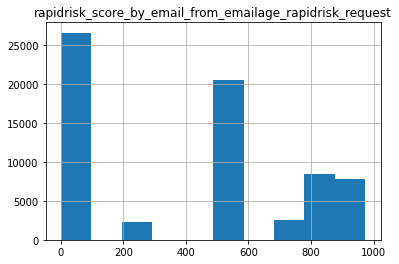

In [19]:
df_features.hist(column='rapidrisk_score_by_email_from_emailage_rapidrisk_request')

In [25]:
df_features.groupby(['rapidrisk_score_by_email_from_emailage_rapidrisk_request', 'SCORE']).count('PAYMENT_TOKEN')

TypeError: count() takes 1 positional argument but 2 were given

In [26]:
conditions = [
    df_features['rapidrisk_score_by_email_from_emailage_rapidrisk_request'].lt(100), 
    df_features['rapidrisk_score_by_email_from_emailage_rapidrisk_request'].ge(101) & df_features['rapidrisk_score_by_email_from_emailage_rapidrisk_request'].le(300), 
    df_features['rapidrisk_score_by_email_from_emailage_rapidrisk_request'].ge(301) & df_features['rapidrisk_score_by_email_from_emailage_rapidrisk_request'].le(600),
    df_features['rapidrisk_score_by_email_from_emailage_rapidrisk_request'].gt(601)]

choices = ['very low', 'low' , 'medium', 'high']

df_features['emailage_bucket'] = np.select(conditions, choices)

In [30]:
df_features.groupby(['emailage_bucket'])['PAYMENT_TOKEN'].nunique()

emailage_bucket
0               2
high        18783
low          2298
medium      20464
very low    26533
Name: PAYMENT_TOKEN, dtype: int64